# Prototype of projection the EIOPA curve n-years year ahead and recalibrating the Smith Wilson algorithm to the new curve

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [6]:
from ImportData import importSWEiopa
from Curves import Curves

In [7]:
paramfile = pd.read_csv("Parameters.csv")
paramfile.index = paramfile["Parameter"]
del paramfile["Parameter"]

## Prepare base EIOPA curve

In [8]:
selected_param_file = paramfile.loc["EIOPA_param_file"][0]
selected_curves_file = paramfile.loc["EIOPA_curves_file"][0]
country = paramfile.loc["country"][0]

[maturities_country, curve_country, extra_param, Qb]= importSWEiopa(selected_param_file, selected_curves_file, country)

###  Import base RFR curve and save in dataframe

In [9]:
df1 = pd.Series(range(1,curve_country.size+1),index=None, name="Maturity")
df2 = pd.Series(data=curve_country.values, index=None, name="Yield")

EIOPA_curve = pd.DataFrame(df1).join(df2)

In [10]:
EIOPA_curve.head()

,Maturity,Yield
0,1,0.03472
1,2,0.03315
2,3,0.03140
3,4,0.03009
4,5,0.02930


### Calculate 1 year forward rates

The forward rates will be used to calculate forward spot curves

In [11]:
fwdata = ((EIOPA_curve["Yield"]+1) ** EIOPA_curve["Maturity"])/((EIOPA_curve["Yield"].shift(periods=1)+1) ** EIOPA_curve["Maturity"].shift(periods=1))

In [12]:
fw = pd.Series(data=fwdata.values, index=None, name="Forward")

In [13]:
EIOPA_curve=EIOPA_curve.join(fw)

In [14]:
display(EIOPA_curve)

,Maturity,Yield,Forward
0,1,0.03472,NaN
1,2,0.03315,1.031582
2,3,0.03140,1.027909
3,4,0.03009,1.026170
4,5,0.02930,1.026146
...,...,...,...
145,146,0.03274,1.034191
146,147,0.03275,1.034211
147,148,0.03276,1.034231
148,149,0.03277,1.034251


### Forward spot rates

$$
y_i(t-i) = \prod_i^t(1+fw_{EIOPA}(t))^{\frac{1}{t-i}}


$$

In [15]:
# Number of projection years
N = int(paramfile.loc["n_proj_years"][0])

In [16]:
EIOPA_curvefwd = EIOPA_curve

for year in range(1,N):
    spot = ((1+EIOPA_curve["Forward"][year:]).cumprod(axis=None)**(1/(EIOPA_curve["Maturity"]-year))-1)[year:]-1
    EIOPA_curvefwd=EIOPA_curvefwd.join(pd.Series(data=spot.values, index=None, name="Yield year"+str(year)))

In [17]:
display(EIOPA_curvefwd)

,Maturity,Yield,Forward,Yield year1,Yield year2,Yield year3,Yield year4,Yield year5,Yield year6,Yield year7,...,Yield year40,Yield year41,Yield year42,Yield year43,Yield year44,Yield year45,Yield year46,Yield year47,Yield year48,Yield year49
0,1,0.03472,NaN,0.031582,0.027909,0.026170,0.026146,0.026663,0.027041,0.027560,...,0.033653,0.033492,0.033733,0.033531,0.034204,0.033982,0.033731,0.033931,0.034131,0.034332
1,2,0.03315,1.031582,0.029745,0.027039,0.026158,0.026404,0.026852,0.027301,0.027925,...,0.033573,0.033612,0.033632,0.033867,0.034093,0.033856,0.033831,0.034031,0.034232,0.034176
2,3,0.03140,1.027909,0.028552,0.026741,0.026326,0.026617,0.027088,0.027631,0.028267,...,0.033626,0.033585,0.033823,0.033906,0.033972,0.033881,0.033931,0.034131,0.034161,0.034184
3,4,0.03009,1.026170,0.027951,0.026722,0.026505,0.026853,0.027389,0.027960,0.027968,...,0.033602,0.033740,0.033862,0.033862,0.033962,0.033944,0.034031,0.034104,0.034171,0.034233
4,5,0.02930,1.026146,0.027693,0.026786,0.026716,0.027140,0.027701,0.027782,0.028841,...,0.033723,0.033788,0.033836,0.033876,0.033996,0.034021,0.034029,0.034123,0.034213,0.034299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,0.03274,1.034191,0.032739,0.032757,0.032801,0.032856,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,147,0.03275,1.034211,0.032749,0.032768,0.032811,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,148,0.03276,1.034231,0.032760,0.032778,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,149,0.03277,1.034251,0.032770,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
EIOPA_curvefwd["Yield year1"].head()

0    0.031582
1    0.029745
2    0.028552
3    0.027951
4    0.027693
Name: Yield year1, dtype: float64

In [19]:
r_Obs = np.transpose(np.array(EIOPA_curvefwd["Yield year1"]))[:-1]

In [20]:
M_Obs = np.transpose(np.array(range(1,r_Obs.size+1)))

In [21]:
# ultimate forward rate
ufr = extra_param["UFR"]/100
# Numeric precision of the optimisation
Precision = float(paramfile.loc["Precision"][0])

# Targeted distance between the extrapolated curve and the ultimate forward rate at the convergence point
Tau = float(paramfile.loc["Tau"][0])# 1 basis point

In [22]:
SWCalibrator = Curves(M_Obs, r_Obs, ufr, Precision, Tau, None)

In [23]:
alphaoptimized = SWCalibrator.BisectionAlpha(0.05, 0.5, M_Obs, r_Obs, ufr, Tau, Precision, 1000)

In [24]:
SWCalibrator.alpha = alphaoptimized

In [25]:
SWCalibrator.b = SWCalibrator.SWCalibrate(SWCalibrator.r_Obs, SWCalibrator.M_Obs, SWCalibrator.ufr, SWCalibrator.alpha)

In [26]:
r_Obs_Est = SWCalibrator.SWExtrapolate(M_Obs, M_Obs, SWCalibrator.b, SWCalibrator.ufr, SWCalibrator.alpha)

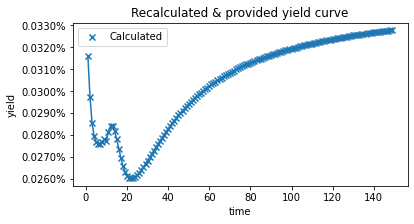

In [27]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(M_Obs, r_Obs, label="Calculated",marker="x")
ax1.plot(M_Obs, r_Obs_Est)
ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()